# Introduction

Muhammad Bintang Ramadhan  
FTDS hacktiv8 batch 8


Dalam Projek Milestone 2 Phase 2 ini, saya ingin membuat projek pendeteksi penggunaan masker. Membagi menjadi 3 kelas yaitu orang yang **menggunakan masker**, **tidak menggunakan masker** dan **tidak menggunakan masker dengan benar**.  
Pada saat ini telah banyak kabar bahwa sekolah dan kampus akan melakukan pendidikan secara tatap muka, tetapi penyakit COVID-19 ini tetap ada dan tetap bisa menyebar walaupun masyarakat telah melakukan vaksinasi, maka ketika penyelenggaraan pendidikan tatap muka masih harus mematuhi protokol kesehatan salah satunya menggunakan masker. Akan tetapi pada faktanya banyak sekali masyarakat yang mengabaikan penggunaan masker ini, sehingga dikhawatirkan dengan adanya pendidikan tatap muka ini menyebabkan cluster penyebaran virus, jika para masyarakat (siswa/mahasiswa) tidak taat pada protokol kesehetan. Oleh karena itu, saya ingin membuat projek pendeteksi penggunaan masker menggunakan kamera, jika ada siswa/mahasiswa yang tidak menggunakan masker atau tidak menggunakan masker dengan baik maka akan terdeteksi kamera dan akan dilakukan teguran oleh pengawas protokol kesehatan.


**Objective**  
Membuat model deep learning CNN (convolutional neural network) untuk melakukan pendeteksian penggunaan masker.

# Import Library

In [34]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np

#Load Data dan EDA visualisasi
from google.colab import drive
import os
import pathlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

#preparation (pipeline)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#modelling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Flatten, BatchNormalization,GlobalAveragePooling2D, Activation
from tensorflow.keras import Input, Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import initializers

#model evaluation
from sklearn.metrics import classification_report

#Inference
from IPython.display import Image
from google.colab import files
from tensorflow.io import read_file
from tensorflow.image import decode_image, resize
from tensorflow import expand_dims

# Import Data

Import data dari google drive dengan masuk kedalam direktori google drive

In [35]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [36]:
#masuk kedalam direktori folder dataset yang akan saya gunakan (dataset berupa Images)
% cd /content/gdrive/MyDrive/mask_detection

/content/gdrive/MyDrive/mask_detection


In [37]:
#untuk memastikan sudah berada di direktori yang benar.
! ls

test  train


# EDA

In [38]:
#Untuk melihat jumlah Images dari tiap kelas

for dirpath, dirnames, filenames in os.walk('.'):
  print(f"Ada {len(dirnames)} folder dan {len(filenames)} gambar di dalam {dirpath}")

Ada 2 folder dan 0 gambar di dalam .
Ada 3 folder dan 0 gambar di dalam ./train
Ada 0 folder dan 600 gambar di dalam ./train/without_mask
Ada 0 folder dan 600 gambar di dalam ./train/with_mask
Ada 0 folder dan 603 gambar di dalam ./train/incorrect_mask
Ada 3 folder dan 0 gambar di dalam ./test
Ada 0 folder dan 86 gambar di dalam ./test/without_mask
Ada 0 folder dan 90 gambar di dalam ./test/with_mask
Ada 0 folder dan 100 gambar di dalam ./test/incorrect_mask


Pada awalnya dataset ini tidak memiliki data test, akan tetapi saya lakukan pemisahan menjadi data train dan test dengan manual memindah-mindahkan gambar dari folder awal. Selain memindah-mindahkan saya menjadi lebih mengenal dataset ini ketika melakukan pemindahan gambar, dari beberapa gambar diantaranya adalah gambar hasil augmented.

In [39]:
#membuat kelas (label) berdasarkan nama folder
data_dir = pathlib.Path('./train/')
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['incorrect_mask' 'with_mask' 'without_mask']


Terdapat 3 kelas dalam dataset ini yaitu:


*   'incorrect_mask' : adalah gambar-gambar seseorang yang tidak menggunakan masker dengan baik, misalnya menggunakan masker tetapi tidak menutupi mulut dan hidung.
*   'with_mask' : adalah gambar-gambar seseorang yang menggunakan masker dengan baik, menutupi mulut dan hidung.
* 'without_mask' : adalah gambar-gambar seseorang yang tidak menggunakan masker sama sekali.





In [40]:
# membuat function view image
def view_random_image(target_dir, target_class):
  target_folder = target_dir + target_class

  random_image = random.sample(os.listdir(target_folder), 1)

  img = mpimg.imread(target_folder + "/" + random_image[0])
  dimensi = img.shape
  plt.imshow(img)
  plt.title(f"Class :{target_class}, Image Shape : {dimensi}")
  # plt.xlabel(dimensi)
  plt.axis("off")

  # print(f"Image Shape : {img.shape}")
  return img

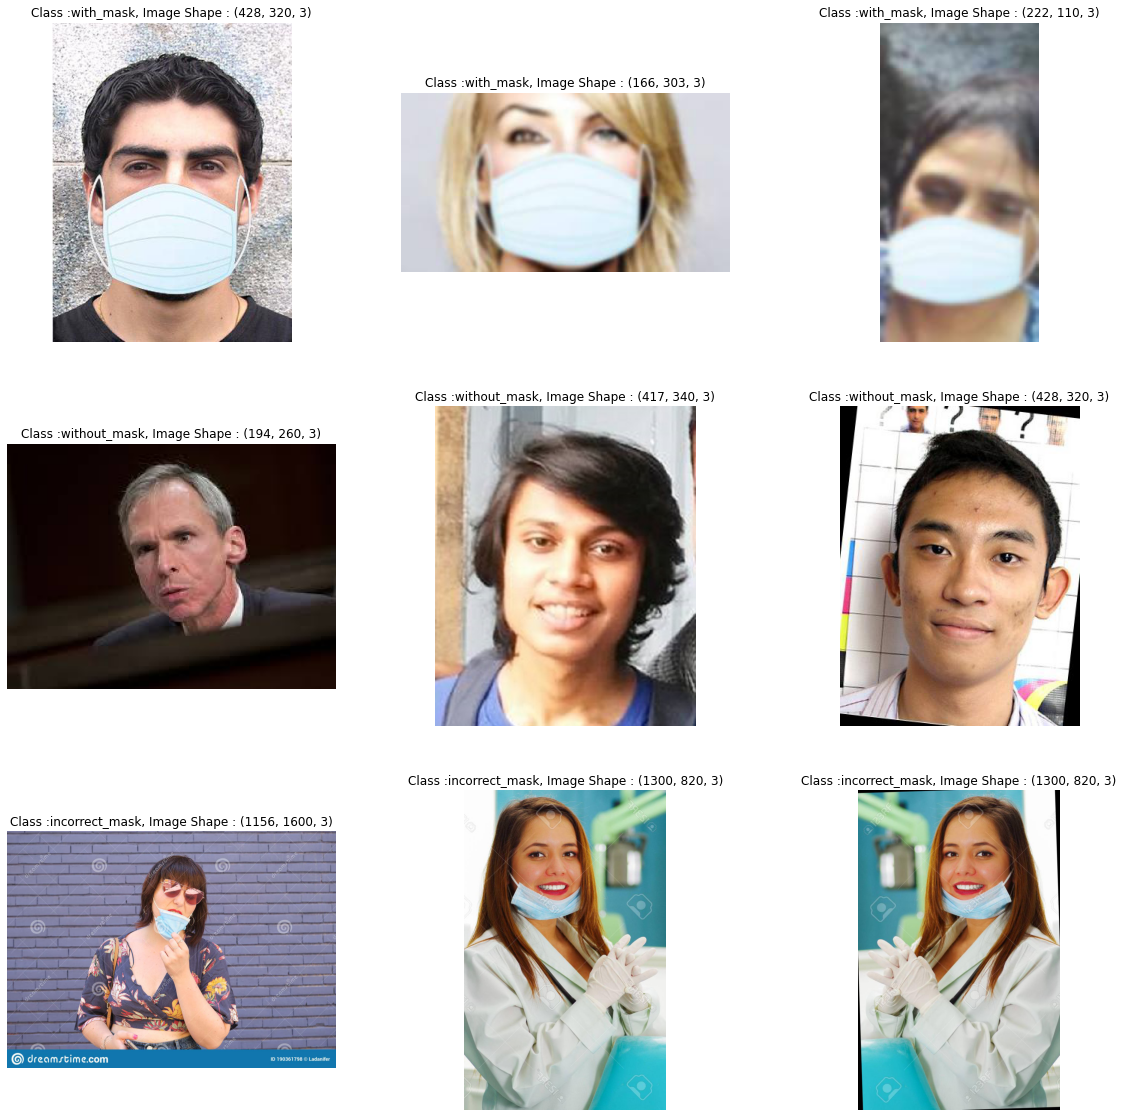

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))

plt.subplot(3,3,1)
# view image kelas 'with_mask'
img = view_random_image(target_dir='./train/',
                        target_class='with_mask')

plt.subplot(3,3,2)
# view image kelas 'with_mask'
img = view_random_image(target_dir='./train/',
                        target_class='with_mask')

plt.subplot(3,3,3)
# view image kelas 'with_mask'
img = view_random_image(target_dir='./train/',
                        target_class='with_mask')

 #============================================================== 

plt.subplot(3,3,4)
# view image kelas 'without_mask'
img = view_random_image(target_dir='./train/',
                        target_class='without_mask')

plt.subplot(3,3,5)
# view image kelas 'without_mask'
img = view_random_image(target_dir='./train/',
                        target_class='without_mask')

plt.subplot(3,3,6)
# view image kelas 'without_mask'
img = view_random_image(target_dir='./train/',
                        target_class='without_mask')

 #============================================================== 


plt.subplot(3,3,7)
# view image kelas 'incorrect_mask'
img = view_random_image(target_dir='./train/',
                        target_class='incorrect_mask')

plt.subplot(3,3,8)
# view image kelas 'incorrect_mask'
img = view_random_image(target_dir='./train/',
                        target_class='incorrect_mask')

plt.subplot(3,3,9)
# view image kelas 'incorrect_mask'
img = view_random_image(target_dir='./train/',
                        target_class='incorrect_mask')


Dalam Dataset ini terdapat beberapa gambar hasil dari augmented dan hasil edit gambar seperti dari kelas with_mask, banyak sekali gambar yang hasil edit menemplekan masker untuk menutupi mulut dan hidung, akan tetapi menurut saya gambar-gambar tersebut masih valid karna mungkin mendapatkan data orang-orang menggunakan masker tidak mudah. Bahkan dari data without_mask diedit ditempelkan masker untuk menutupi mulut dan hidungnya.  
Gambar Incorrect mask cukup beragam, ada yang tidak menutup hidung saja, ada yang tidak menutup mulut saja dan bahkan ada yang ditempel di dagu, sangat relevan dengan kondisi di lapangannya banyak sekali yang tidak menggunakan masker dengan baik seperti dari data-data dataset ini.  
  
Dataset ini tidak memiliki ukuran gambar yang sama, maka untuk melakukan pemodelan harus menyamakan ukuran gambar terlebih dahulu.

# Loading Data

In [42]:
tf.random.set_seed(8)

#deklarasikan object
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
train_datagen_augmented = ImageDataGenerator(rescale=1./255,
                                             rotation_range=0.2,
                                             zoom_range=0.2,
                                             width_shift_range=0.2,
                                             height_shift_range=0.2,
                                             horizontal_flip=True)

# set direktori
train_dir = './train/'
test_dir = './test/'

#set data generator
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=32,
                                               target_size=(300, 300),
                                               class_mode='categorical',
                                               seed=8)


valid_data = valid_datagen.flow_from_directory(test_dir,
                                               batch_size=32,
                                               target_size=(300, 300),
                                               class_mode='categorical',
                                               seed=8)

train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                               batch_size=32,
                                               target_size=(300, 300),
                                               class_mode='categorical',
                                               seed=8)

Found 1803 images belonging to 3 classes.
Found 276 images belonging to 3 classes.
Found 1803 images belonging to 3 classes.


Pada dataset awal sudah ada gambar-gambar hasil augmentasi, disini untuk melakukan pemodelan saya juga akan mencoba membuat augmentasi gambar lagi, untuk mencari hasil model terbaik.

# Modelling

## Base Model

In [47]:
#base model

#cnn
model = Sequential()
model.add(Conv2D(16, 3, activation='relu', input_shape=(300, 300, 3)))
model.add(MaxPool2D(2))
model.add(Conv2D(32, 3, activation='relu'))
model.add(MaxPool2D(2))
model.add(Conv2D(64, 3, activation='relu'))
model.add(MaxPool2D(2))
model.add(Conv2D(128, 3, activation='relu'))
model.add(MaxPool2D(2))
#fully connected
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(3, activation='softmax'))

# model compile
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(train_data,
                    epochs=30,
                    validation_data=valid_data)

Epoch 1/30
57/57 [==============================] - 29s 457ms/step - loss: 0.8339 - accuracy: 0.6251 - val_loss: 0.5445 - val_accuracy: 0.8007
Epoch 2/30
57/57 [==============================] - 26s 448ms/step - loss: 0.4229 - accuracy: 0.8441 - val_loss: 0.4066 - val_accuracy: 0.8587
Epoch 3/30
57/57 [==============================] - 26s 449ms/step - loss: 0.2921 - accuracy: 0.8924 - val_loss: 0.2584 - val_accuracy: 0.9094
Epoch 4/30
57/57 [==============================] - 26s 457ms/step - loss: 0.1987 - accuracy: 0.9273 - val_loss: 0.1738 - val_accuracy: 0.9457
Epoch 5/30
57/57 [==============================] - 26s 449ms/step - loss: 0.1335 - accuracy: 0.9506 - val_loss: 0.1635 - val_accuracy: 0.9493
Epoch 6/30
57/57 [==============================] - 26s 447ms/step - loss: 0.0721 - accuracy: 0.9750 - val_loss: 0.1874 - val_accuracy: 0.9384
Epoch 7/30
57/57 [==============================] - 26s 450ms/step - loss: 0.0546 - accuracy: 0.9839 - val_loss: 0.0918 - val_accuracy: 0.9638

In [48]:
metrics = pd.DataFrame(history.history)

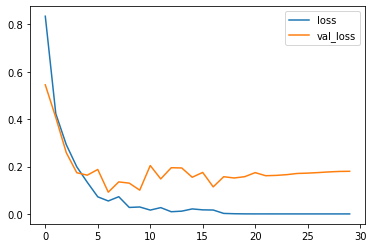

In [49]:
metrics[['loss', 'val_loss']].plot();

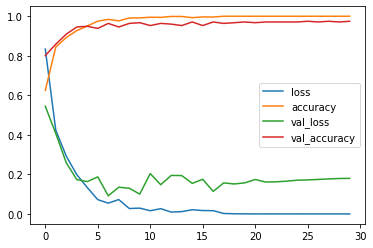

In [51]:
metrics.plot();

In [52]:
loss, accuracy = model.evaluate(valid_data)
print('Test accuracy :', accuracy)
print('Test loss :', loss)

9/9 [==============================] - 5s 510ms/step - loss: 0.1798 - accuracy: 0.9746
Test accuracy : 0.9746376872062683
Test loss : 0.1798488199710846


Menurut saya hasil dari base model yang saya buat ini termasuk sudah baik, los dan val loss melandai tetapi ada gap antara loss dan val loss, menurut saya kemungkinan over fit jika menggunakan epoch yang banyak.
Accuracy juga sangat tinggi, untuk kasus ini saya rasa base model ini sudah cukup baik.  
Terlihat base model ini juga tidak vanishing dan tidak exploding gradient. setelah ini saya akan mencoba improve model dengan mencoba menggunakan metode transfer learning dan mencoba improve base model ini untuk menghandle over fit dengan megurangi layer.

## Model Transfer Learning ResNet50V2

In [43]:
base_model = tf.keras.applications.resnet_v2.ResNet50V2(input_shape=(300, 300, 3),
                                                        include_top=False,
                                                        weights='imagenet')
base_model.trainable = False

94683136/94668760 [==============================] - 1s 0us/step


In [44]:
global_average_layer = GlobalAveragePooling2D()
layer_1 = Dense(15, activation='relu')
prediction_layer = Dense(3)
softmax = Activation('softmax')

inputs = Input(shape=(300, 300, 3))
x = base_model(inputs, training=False)
x = global_average_layer(x)
x = Dropout(0.2)(x)
x = layer_1(x)
outputs = prediction_layer(x)
outputs = softmax(outputs)

model_tl = Model(inputs, outputs)

# compile model
model_tl.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# train model
history_tl = model_tl.fit(train_data,
                    epochs=30,
                    validation_data=valid_data)

Epoch 1/30
57/57 [==============================] - 113s 2s/step - loss: 0.2241 - accuracy: 0.9262 - val_loss: 0.0557 - val_accuracy: 0.9855
Epoch 2/30
57/57 [==============================] - 31s 547ms/step - loss: 0.0431 - accuracy: 0.9884 - val_loss: 0.0386 - val_accuracy: 0.9891
Epoch 3/30
57/57 [==============================] - 32s 552ms/step - loss: 0.0195 - accuracy: 0.9961 - val_loss: 0.0160 - val_accuracy: 0.9928
Epoch 4/30
57/57 [==============================] - 32s 557ms/step - loss: 0.0127 - accuracy: 0.9961 - val_loss: 0.0076 - val_accuracy: 1.0000
Epoch 5/30
57/57 [==============================] - 32s 553ms/step - loss: 0.0090 - accuracy: 0.9978 - val_loss: 0.0153 - val_accuracy: 0.9891
Epoch 6/30
57/57 [==============================] - 32s 561ms/step - loss: 0.0078 - accuracy: 0.9983 - val_loss: 0.0056 - val_accuracy: 1.0000
Epoch 7/30
57/57 [==============================] - 32s 559ms/step - loss: 0.0036 - accuracy: 0.9989 - val_loss: 0.0213 - val_accuracy: 0.9891
E

In [ ]:
metrics_tl = pd.DataFrame(history_tl.history)

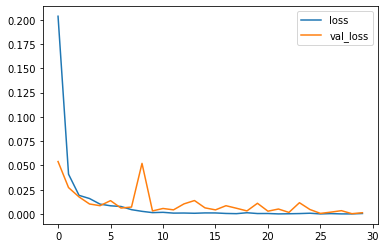

In [ ]:
metrics_tl[['loss', 'val_loss']].plot();

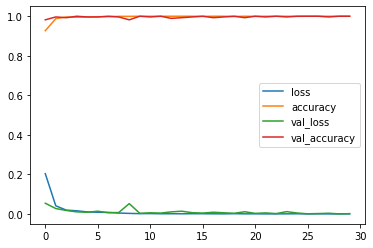

In [ ]:
metrics_tl.plot();

In [46]:
loss, accuracy = model_tl.evaluate(valid_data)
print('Test accuracy :', accuracy)
print('Test loss :', loss)

9/9 [==============================] - 6s 602ms/step - loss: 0.0037 - accuracy: 0.9964
Test accuracy : 0.9963768124580383
Test loss : 0.0036691322457045317


Setelah mencoba menggunakan base model, saya mencoba menggunakan model yang telah ditrain sebelumnya atau disebut model-model pre-train. Saya menggunakan model dari ResNet50V2 dengan weights 'image net'.  
Hasilnya sangat memuaskan, menggunakan base model saja sudah baik hasilnya tentunya dengan menggunakan model hasil pre-train ini sangat baik sekali, bahkan dari epoch 1 sudah memiliki loss dan val loss yang sangat kecil dan memiliki accuracy dan val accuracy yang sangat tinggi.  
Kemungkinan saya akan menggunakan model ini untuk melakukan deployment.  
Tetapi saya akan mencoba improvement dari base model terlebih dahulu.

## Model Improvement

In [53]:
#cnn
model_improvement = Sequential()
# train_dataset = tf.data.Dataset.from_tensor_slices((train_data_augmented)) #pipeline
# train_dataset = train_dataset.shuffle(100).repeat(2).batch(36) #pipeline
model_improvement.add(Conv2D(32, 3, activation='relu', input_shape=(300, 300, 3)))
model_improvement.add(MaxPool2D(2))
model_improvement.add(Conv2D(64, 3, activation='relu'))
model_improvement.add(MaxPool2D(2))
# model_improvement.add(Conv2D(64, 3, activation='relu'))
# model_improvement.add(MaxPool2D(2))
# model_improvement.add(Conv2D(128, 3, activation='relu'))
# model_improvement.add(MaxPool2D(2))
#fully connected
model_improvement.add(Flatten())
model_improvement.add(Dense(32, activation='relu'))
model_improvement.add(Dropout(0.1)) #dropout setelah masuk layer
model_improvement.add(BatchNormalization()) #normalisasi sebelum masuk layer
model_improvement.add(Dense(10, activation='relu', kernel_initializer=keras.initializers.HeUniform()))
model_improvement.add(Dense(3, activation='softmax'))

# model_improvement compile
model_improvement.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history_improvement = model_improvement.fit(train_data_augmented,
                    epochs=30,
                    validation_data=valid_data)

Epoch 1/30
57/57 [==============================] - 65s 1s/step - loss: 1.0513 - accuracy: 0.4498 - val_loss: 2.0508 - val_accuracy: 0.3261
Epoch 2/30
57/57 [==============================] - 67s 1s/step - loss: 0.8598 - accuracy: 0.5929 - val_loss: 0.9378 - val_accuracy: 0.4783
Epoch 3/30
57/57 [==============================] - 62s 1s/step - loss: 0.7174 - accuracy: 0.6944 - val_loss: 0.7918 - val_accuracy: 0.8478
Epoch 4/30
57/57 [==============================] - 61s 1s/step - loss: 0.6256 - accuracy: 0.7682 - val_loss: 1.0402 - val_accuracy: 0.5435
Epoch 5/30
57/57 [==============================] - 60s 1s/step - loss: 0.5305 - accuracy: 0.8098 - val_loss: 0.4268 - val_accuracy: 0.8841
Epoch 6/30
57/57 [==============================] - 60s 1s/step - loss: 0.4419 - accuracy: 0.8369 - val_loss: 0.3930 - val_accuracy: 0.8551
Epoch 7/30
57/57 [==============================] - 60s 1s/step - loss: 0.4098 - accuracy: 0.8447 - val_loss: 0.2978 - val_accuracy: 0.9167
Epoch 8/30
57/57 [==

In [54]:
metrics_model_improvement = pd.DataFrame(history_improvement.history)

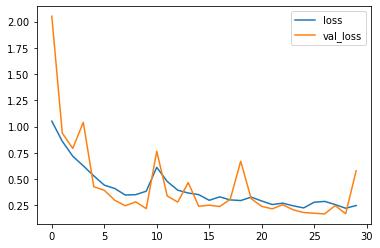

In [55]:
metrics_model_improvement[['loss', 'val_loss']].plot();

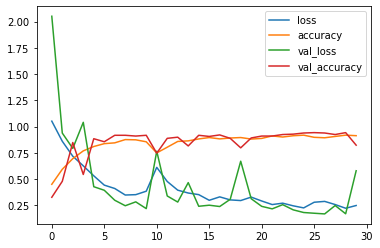

In [56]:
metrics_model_improvement.plot();

In [57]:
loss, accuracy = model_improvement.evaluate(valid_data)
print('Test accuracy :', accuracy)
print('Test loss :', loss)

9/9 [==============================] - 4s 470ms/step - loss: 0.5787 - accuracy: 0.8225
Test accuracy : 0.8224637508392334
Test loss : 0.578677237033844


Dalam improve model ini saya coba mengurangi convolusi layer, menambahkan batchnormalization, weight initializer, dropout dan mencoba menggunakan data hasil augmentasi. Akan tetapi hasilnya tidak lebih baik dari base modelnya, accuracy menurun dan loss meningkat akan dan hasilnya juga menjadi Exploding Gradient, menurut saya karna saya kurangi convolusi layer model menjadi tidak lebih baik karena mungkin sudah pas dengan layer seperti di base model, menjadi exploding gradient mungkin karena saya mencoba-coba menambahkan batchnormalization, weight initializer, dropout dan mencoba menggunakan data hasil augmentasi. Tujuan utamanya mencoba improve model agar tidak overfit, hasilnya malah semakin exploding gradient dan accuracy & loss nya menjadi tidak lebih baik.  
Disini saya juga terlalu banyak mencoba hal-hal lain yang tidak sesuai tujuan utamanya. 

# Model Inference

In [ ]:
files.upload()

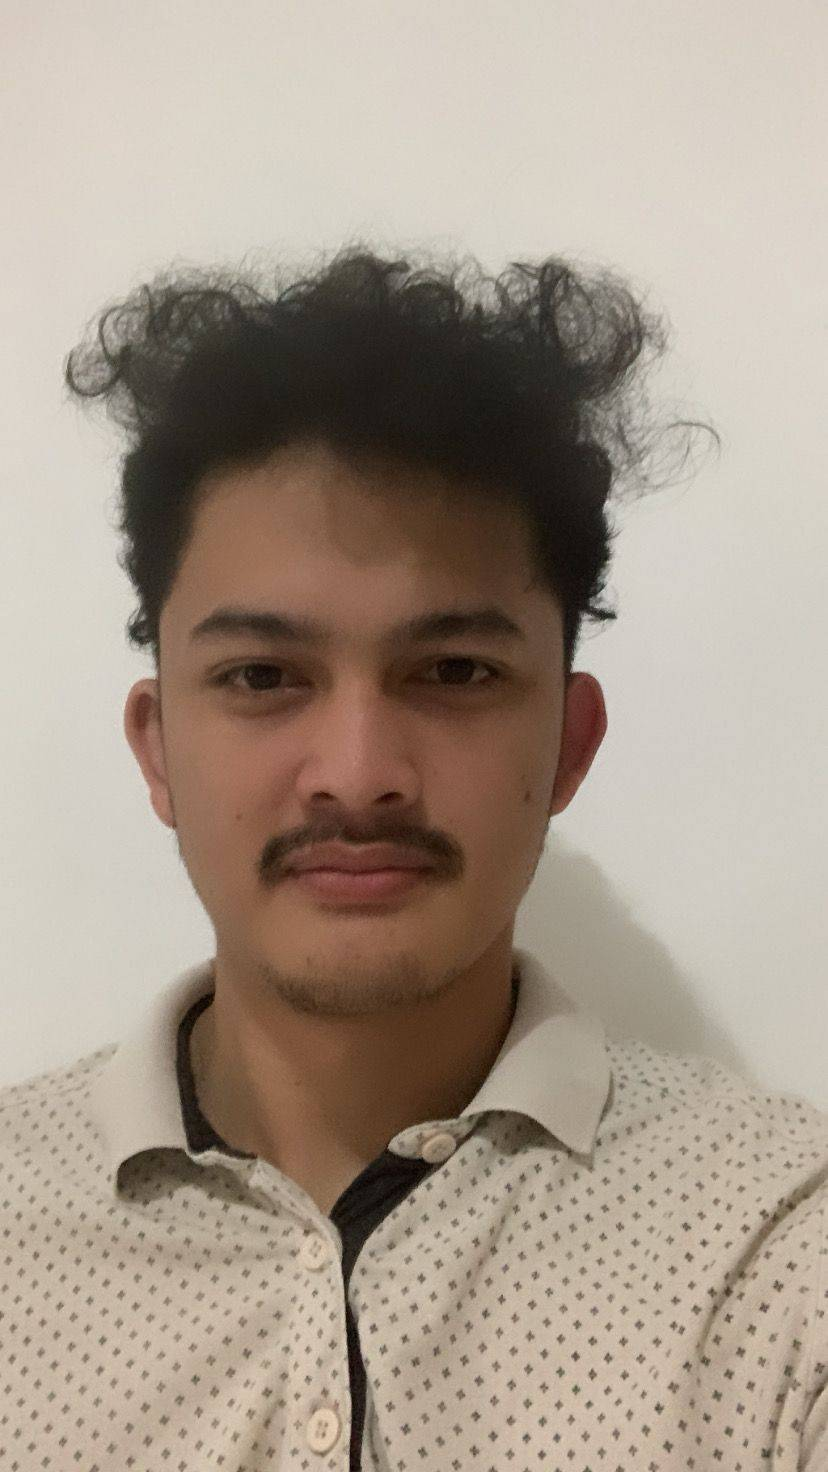

In [ ]:
Image('nomask.jpg', width=100)

In [ ]:
new_img = mpimg.imread('nomask.jpg')

In [ ]:
def load_and_preprocess(filename, img_shape=300):
  img = read_file(filename)
  img = decode_image(img, channels=3)
  img = resize(img, size=[img_shape, img_shape])
  img = img/225
  return img

In [ ]:
new_img = load_and_preprocess('nomask.jpg')
new_img.shape

TensorShape([300, 300, 3])

In [ ]:
from tensorflow import expand_dims
#benerin dimensi
new_img = expand_dims(new_img, axis=0)
new_img.shape

TensorShape([1, 300, 300, 3])

In [ ]:
res = model_tl.predict(new_img)
res.argmax()

2

In [ ]:
train_data.class_indices

{'incorrect_mask': 0, 'with_mask': 1, 'without_mask': 2}

Data Inference terprediksi benar, hasil prediksi 2 yaitu without_mask

# Save Model

In [ ]:
model_tl.save("model_tl.h5")

# Conclussion

## EDA
Dataset yang saya gunakan dalam project ini tidak terlalu besar.
Dataset ini memiliki banyak gambar hasil edit contohnya adalah foto seseorang yang tidak menggunakan masker diedit dengan menempelkan masker agar menyerupai seseorang yang saat menggunakan masker, tetapi menurut saya itu masih valid untuk dilakukan training karna hasilnya akan sama saja dengan ngetrain seseorang yang menggunakan masker asli.  
Dataset ini juga memiliki gambar-gambar yang hasil dari augmentasi image dari pemilik datasetnya. Mungkin dikarenakan kesulitan mengumpulkan data-data ini.

## Model  
Dalam kasus ini, menggunakan base model saja sebenarnya sudah baik. Akan tetapi ketika saya mencoba menggunakan metode transfer learning dari model ResNet50V2 hasilnya sangat lebih memuaskan dengan hasil accuracy dan val accuracy sudah tinggi dari epoch 1, loss dan val loss pun sudah sangat kecil dari epoch 1 sehingga saya memutuskan untuk menggunakan model tersebut dalam melakukan deployment. 